# 03 — Joins & Greece vs Abroad Comparison
**Requires:** Run `01_load_and_filter.ipynb` first.

Join Greek players with club and competition data to compare market values between players in Greece vs abroad.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn-v0_8-whitegrid')

OUTPUTS_PATH = "../outputs/"
FIGURES_PATH = "../outputs/figures/"

greek_active = pd.read_parquet(OUTPUTS_PATH + "greek_active.parquet")
clubs        = pd.read_parquet(OUTPUTS_PATH + "clubs.parquet")

print("greek_active:", greek_active.shape)
print("clubs:       ", clubs.shape)
print("clubs.info():", clubs.info())

greek_active: (195, 24)
clubs:        (451, 17)
<class 'pandas.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  451 non-null    int64  
 1   club_code                451 non-null    str    
 2   name                     451 non-null    str    
 3   domestic_competition_id  451 non-null    str    
 4   total_market_value       0 non-null      float64
 5   squad_size               451 non-null    int64  
 6   average_age              413 non-null    float64
 7   foreigners_number        451 non-null    int64  
 8   foreigners_percentage    399 non-null    float64
 9   national_team_players    451 non-null    int64  
 10  stadium_name             451 non-null    str    
 11  stadium_seats            451 non-null    int64  
 12  net_transfer_record      451 non-null    str    
 13  coach_name               0 non-null      fl

## 3.1 Join with Clubs

In [9]:
greek_enriched = greek_active.merge(
    clubs[["club_id", "name", "domestic_competition_id", "total_market_value", "average_age"]]
    .rename(columns={"average_age": "team_average_age"}),
    left_on="current_club_id",
    right_on="club_id",
    how="left",
    suffixes=("", "_club")
)

print("Shape after join:", greek_enriched.shape)
print("\nUnmatched (no club found):", greek_enriched["club_id"].isna().sum())
greek_enriched[["name", "position", "domestic_competition_id", "market_value_in_eur", "current_club_name", "team_average_age"]].head()
# print(greek_enriched.info())

Shape after join: (195, 29)

Unmatched (no club found): 0


,name,position,domestic_competition_id,market_value_in_eur,current_club_name,team_average_age
0,Athanasios Papageorgiou,Defender,GR1,25000.0,Athlitiki Enosi Larisas,28.8
1,Nikolaos Karelis,Attack,GR1,350000.0,Panserraikos Serres,25.6
2,Kostas Lamprou,Goalkeeper,NL1,150000.0,Nooit Opgeven Altijd Doorzetten Aangenaam Door...,25.9
3,Nikolaos Kaltsas,Attack,GR1,175000.0,A.G.S Asteras Tripolis,29.1
4,Alexandros Paschalakis,Goalkeeper,GR1,400000.0,Olympiakos Syndesmos Filathlon Peiraios,26.5


## 3.2 Flag: Playing in Greece or Abroad

In [10]:
# Check what the Greek league ID looks like in the data
print(greek_enriched["current_club_domestic_competition_id"].value_counts().head(15))

current_club_domestic_competition_id
GR1     166
PO1       7
NL1       4
IT1       3
L1        3
GB1       3
TR1       2
BE1       2
ES1       1
DK1       1
UKR1      1
SC1       1
FR1       1
Name: count, dtype: int64


In [12]:
GREEK_LEAGUE_ID = "GR1"  # adjust if the print above shows a different value

greek_enriched["plays_in_greece"] = (
    greek_enriched["current_club_domestic_competition_id"] == GREEK_LEAGUE_ID
)

print(greek_enriched["plays_in_greece"].value_counts())

plays_in_greece
True     166
False     29
Name: count, dtype: int64


## 3.3 Greece vs Abroad — Market Value Comparison

/var/folders/x4/f0qpy7gd3lzdpz89zcyrt3mw0000gn/T/ipykernel_36454/1538100871.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(groups, labels=["In Greece", "Abroad"], patch_artist=True,


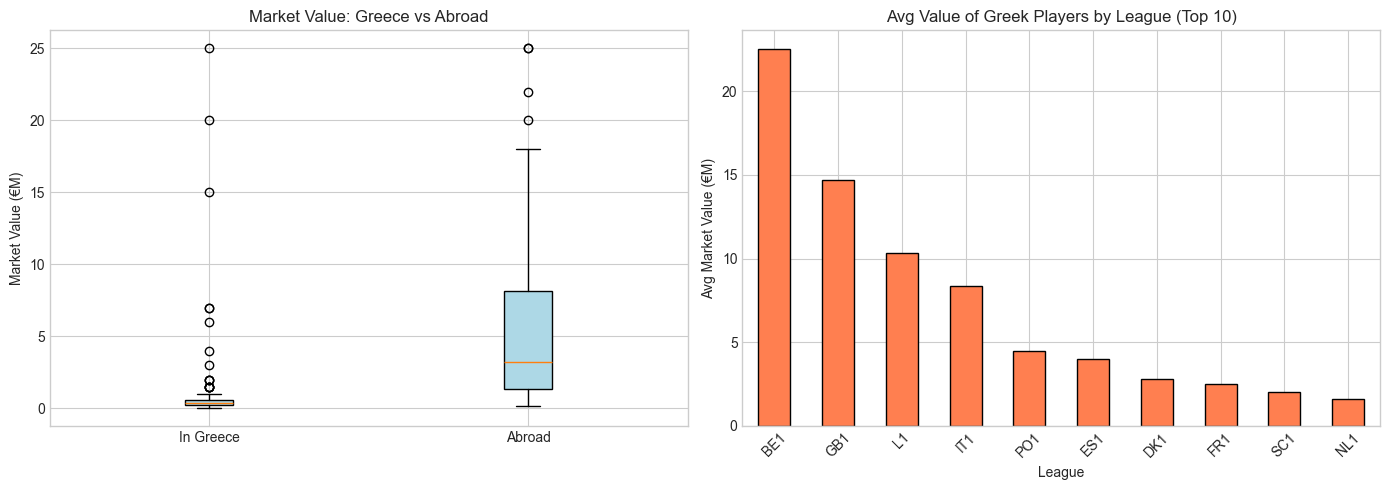

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot
groups = [
    greek_enriched[greek_enriched["plays_in_greece"] == True]["market_value_in_eur"].dropna() / 1e6,
    greek_enriched[greek_enriched["plays_in_greece"] == False]["market_value_in_eur"].dropna() / 1e6,
]
axes[0].boxplot(groups, labels=["In Greece", "Abroad"], patch_artist=True,
                boxprops=dict(facecolor="lightblue"))
axes[0].set_ylabel("Market Value (€M)")
axes[0].set_title("Market Value: Greece vs Abroad")

# Mean value per league (top 10)
league_value = (
    greek_enriched.groupby("current_club_domestic_competition_id")["market_value_in_eur"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
    / 1e6
)
league_value.plot(kind="bar", ax=axes[1], color="coral", edgecolor="black")
axes[1].set_title("Avg Value of Greek Players by League (Top 10)")
axes[1].set_xlabel("League")
axes[1].set_ylabel("Avg Market Value (€M)")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(FIGURES_PATH + "03_greece_vs_abroad.png", dpi=150)
plt.show()

## 3.4 Statistical Test — Is the Difference Significant?

In [14]:
greece_vals = greek_enriched[greek_enriched["plays_in_greece"] == True]["market_value_in_eur"].dropna()
abroad_vals = greek_enriched[greek_enriched["plays_in_greece"] == False]["market_value_in_eur"].dropna()

# Mann-Whitney U (non-parametric, because values are skewed)
stat, p_val = stats.mannwhitneyu(greece_vals, abroad_vals, alternative="two-sided")

print(f"Mann-Whitney U Test")
print(f"  Median value in Greece: €{greece_vals.median():>12,.0f}")
print(f"  Median value abroad:    €{abroad_vals.median():>12,.0f}")
print(f"  p-value: {p_val:.4f} — {'SIGNIFICANT (p < 0.05)' if p_val < 0.05 else 'not significant'}")

Mann-Whitney U Test
  Median value in Greece: €     350,000
  Median value abroad:    €   3,250,000
  p-value: 0.0000 — SIGNIFICANT (p < 0.05)


## 3.5 Value by Position: Greece vs Abroad

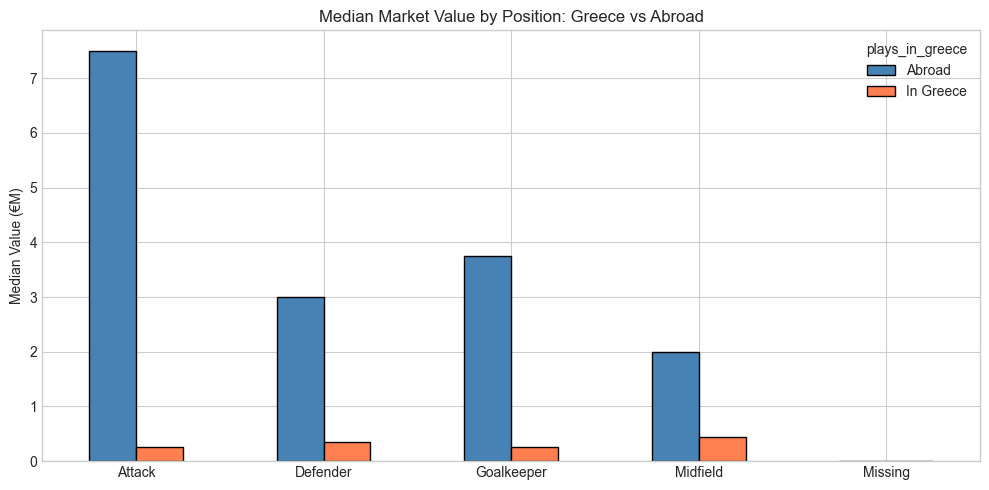

In [15]:
pos_comparison = (
    greek_enriched.groupby(["position", "plays_in_greece"])["market_value_in_eur"]
    .median()
    .unstack()
    .rename(columns={True: "In Greece", False: "Abroad"})
    / 1e6
)

pos_comparison.plot(kind="bar", figsize=(10, 5), color=["steelblue", "coral"], edgecolor="black")
plt.title("Median Market Value by Position: Greece vs Abroad")
plt.ylabel("Median Value (€M)")
plt.xlabel("")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(FIGURES_PATH + "03_value_by_position.png", dpi=150)
plt.show()

## 3.6 Save Enriched Dataset

In [17]:
greek_enriched.to_parquet(OUTPUTS_PATH + "greek_enriched.parquet", index=False)
print("Saved greek_enriched.parquet")

Saved greek_enriched.parquet
